In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from torchvision import datasets, models, transforms
import numpy as np
import pandas as pd
from pathlib import Path
import os
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
import PIL
import torch.nn.functional as F
from PIL import Image
from typing import Tuple
from tqdm import tqdm
import pickle
import os
from sklearn.preprocessing import LabelEncoder
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties


warnings.filterwarnings("ignore")

train_on_gpu = torch.cuda.is_available()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
class SimpsonsDataset(Dataset):
    def __init__(self, files_path, data_transforms):
        super().__init__()
        self.files_path = files_path
        self.transform = data_transforms
        if 'test' not in str(self.files_path[0]):
            self.labels = [path.parent.name for path in self.files_path]
            self.label_encoder = LabelEncoder()
            self.label_encoder.fit(self.labels)
            with open('label_encoder.pkl', 'wb') as le_dump_file:
                pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return len(self.files_path)

    def __getitem__(self, idx):
        img_path = str(self.files_path[idx])
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)
        if 'test' in str(self.files_path[0]):
            return image
        else:
            label_str = str(self.files_path[idx].parent.name)
            label = self.label_encoder.transform([label_str]).item()
            return image, label
     

In [3]:
train_dir = Path('/kaggle/input/the-simpsons-characters-dataset/simpsons_dataset/')
test_dir = Path('/kaggle/input/the-simpsons-characters-dataset/kaggle_simpson_testset/')
train_val_files_path = sorted(list(train_dir.rglob('*.jpg')))
test_path = sorted(list(test_dir.rglob('*.jpg')))
train_val_labels = [path.parent.name for path in train_val_files_path]
train_files_path, val_files_path = train_test_split(train_val_files_path, test_size = 0.3, stratify=train_val_labels)
num_classes = len(np.unique(train_val_labels))
print("Number of classes:", num_classes)

Number of classes: 42


In [4]:
input_size = 224

train_dataset = SimpsonsDataset(train_files_path, transforms.Compose([transforms.Resize((input_size,input_size)), transforms.ToTensor()]))
val_dataset = SimpsonsDataset(val_files_path, transforms.Compose([transforms.Resize((input_size,input_size)), transforms.ToTensor()]))
test_dataset = SimpsonsDataset(test_path, transforms.Compose([transforms.Resize((input_size,input_size)), transforms.ToTensor()]))
print("Number of train samples:", len(train_dataset))
print("Number of test samples:", len(test_dataset))

Number of train samples: 29306
Number of test samples: 990


In [5]:
classes = ['abraham_grampa_simpson', 'agnes_skinner', 'apu_nahasapeemapetilon', 'barney_gumble', 'bart_simpson', 'carl_carlson',
    'charles_montgomery_burns', 'chief_wiggum', 'cletus_spuckler', 'comic_book_guy', 'disco_stu', 'edna_krabappel', 'fat_tony',
    'gil', 'groundskeeper_willie', 'homer_simpson', 'kent_brockman', 'krusty_the_clown', 'lenny_leonard', 'lionel_hutz', 'lisa_simpson',
    'maggie_simpson', 'marge_simpson', 'martin_prince', 'mayor_quimby', 'milhouse_van_houten','miss_hoover', 'moe_szyslak', 'ned_flanders',
    'nelson_muntz', 'otto_mann', 'patty_bouvier', 'principal_skinner', 'professor_john_frink','rainier_wolfcastle', 'ralph_wiggum', 'selma_bouvier',
    'sideshow_bob', 'sideshow_mel','simpsons_dataset', 'snake_jailbird', 'troy_mcclure', 'waylon_smithers'
    ]

def show_images(batch_size, dload): 
    f, ax = plt.subplots(int(batch_size / 4), 4, figsize = (12, 12))
    ax = ax.flatten()
    
    dataiter = iter(dload)
    images, labels = next(dataiter)
    j = 0
    for a in ax:
        npimg = images[j].numpy()
        a.imshow(np.transpose(npimg, (1, 2, 0)))
        a.set_title(classes[labels[j]])
        j+=1
    
    plt.subplots_adjust(left=None, bottom=0.2, right=None, top=None, wspace=None, hspace=None)
    plt.show()

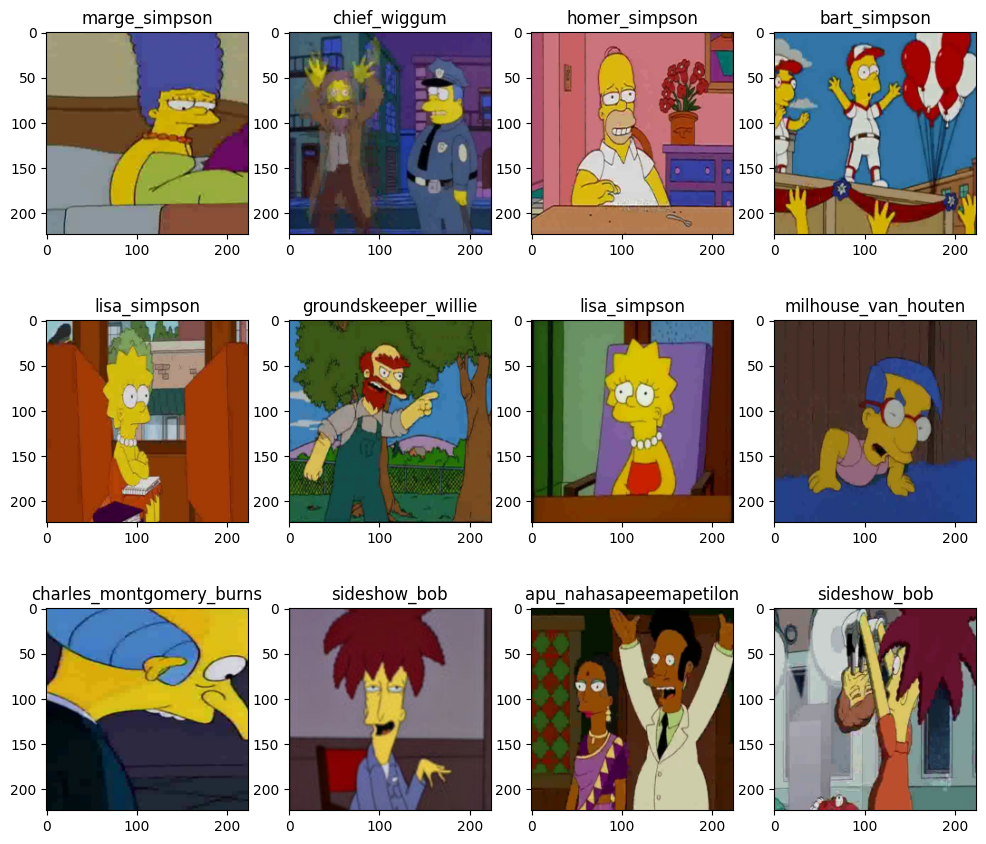

In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

show_images(12, train_dataloader)

In [7]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
    def forward(self, x):
        out = self.block(x)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_classes=42):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(2)

        self.blocks = nn.Sequential(block(32, 64, 1), block(64, 128, 1))
        self.blocks1 = nn.Sequential(block(128, 256, 1), block(256, 256, 1))
        self.fc = nn.Linear(16 * 28 * 28, num_classes)
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        out = self.max_pool(out)

        out = self.blocks(out)
        out = self.blocks1(out)
        
        out = out.view(out.size(0), -1)
        out = self.fc(out)

        return out

In [8]:
resNet = ResNet(BasicBlock)
resNet

ResNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (relu): ReLU()
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (blocks): Sequential(
    (0): BasicBlock(
      (block): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): BasicBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
  )
  (blocks1): Sequential(
    (0): BasicBlock(
      (block): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, di

In [9]:
learning_rate = 0.001
num_epochs = 25

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resNet.to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resNet.parameters(), lr = learning_rate)
device

device(type='cuda', index=0)

In [10]:
import time

from tqdm import tqdm

for epoch in range(num_epochs):
    start_t = time.time()
    correct = 0
    total = 0
    running_loss = 0.0

    for inputs, labels in tqdm(train_dataloader, desc='train batches', total = len(train_dataloader)):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resNet(inputs)

        _, predicted = torch.max(outputs.data, 1)
        correct += int((predicted == labels).sum())
        
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        total += len(outputs)
        running_loss += loss.item()
    end_t = time.time()
    print(f'Epoch = {epoch + 1}, Loss = {running_loss / len(train_dataloader)}, Time = {end_t - start_t}, Accuracy = {correct / total}')

train batches: 100%|██████████| 916/916 [01:23<00:00, 10.97it/s]


Epoch = 1, Loss = 1.9591666477280933, Time = 83.53608679771423, Accuracy = 0.46338633726881867


train batches: 100%|██████████| 916/916 [00:56<00:00, 16.17it/s]


Epoch = 2, Loss = 0.5518640673040173, Time = 56.65665602684021, Accuracy = 0.8502013239609636


train batches: 100%|██████████| 916/916 [00:56<00:00, 16.16it/s]


Epoch = 3, Loss = 0.21250833420786502, Time = 56.69454264640808, Accuracy = 0.9391592165426875


train batches: 100%|██████████| 916/916 [00:56<00:00, 16.25it/s]


Epoch = 4, Loss = 0.10712924184056896, Time = 56.367663860321045, Accuracy = 0.96778816624582


train batches: 100%|██████████| 916/916 [00:56<00:00, 16.10it/s]


Epoch = 5, Loss = 0.0732459771929448, Time = 56.896486043930054, Accuracy = 0.9784003275779704


train batches: 100%|██████████| 916/916 [00:56<00:00, 16.16it/s]


Epoch = 6, Loss = 0.06892666376141707, Time = 56.68795824050903, Accuracy = 0.9788780454514434


train batches: 100%|██████████| 916/916 [00:57<00:00, 16.05it/s]


Epoch = 7, Loss = 0.05161335433932162, Time = 57.06836175918579, Accuracy = 0.9854637275643213


train batches: 100%|██████████| 916/916 [00:56<00:00, 16.13it/s]


Epoch = 8, Loss = 0.052188855634506474, Time = 56.788269996643066, Accuracy = 0.9847130280488637


train batches: 100%|██████████| 916/916 [00:56<00:00, 16.17it/s]


Epoch = 9, Loss = 0.04306657555717049, Time = 56.649996280670166, Accuracy = 0.9875793352897018


train batches: 100%|██████████| 916/916 [00:57<00:00, 16.03it/s]


Epoch = 10, Loss = 0.04829942528608805, Time = 57.139082193374634, Accuracy = 0.9857025865010578


train batches: 100%|██████████| 916/916 [00:57<00:00, 15.94it/s]


Epoch = 11, Loss = 0.0439290778129582, Time = 57.45616173744202, Accuracy = 0.987203985531973


train batches: 100%|██████████| 916/916 [00:57<00:00, 15.98it/s]


Epoch = 12, Loss = 0.03810968549710871, Time = 57.33494544029236, Accuracy = 0.9894560840783457


train batches: 100%|██████████| 916/916 [00:59<00:00, 15.52it/s]


Epoch = 13, Loss = 0.040436131772587605, Time = 59.02125835418701, Accuracy = 0.9889783662048727


train batches: 100%|██████████| 916/916 [00:57<00:00, 15.98it/s]


Epoch = 14, Loss = 0.032751730009116145, Time = 57.32588076591492, Accuracy = 0.9911280966355013


train batches: 100%|██████████| 916/916 [00:57<00:00, 16.00it/s]


Epoch = 15, Loss = 0.03512220465254451, Time = 57.243370056152344, Accuracy = 0.9904456425305398


train batches: 100%|██████████| 916/916 [00:57<00:00, 15.97it/s]


Epoch = 16, Loss = 0.03541437216652006, Time = 57.37419295310974, Accuracy = 0.9909233604040129


train batches: 100%|██████████| 916/916 [00:57<00:00, 16.02it/s]


Epoch = 17, Loss = 0.033819436688744306, Time = 57.1807656288147, Accuracy = 0.9915034463932301


train batches: 100%|██████████| 916/916 [00:57<00:00, 15.90it/s]


Epoch = 18, Loss = 0.032445463639663316, Time = 57.63010621070862, Accuracy = 0.9911280966355013


train batches: 100%|██████████| 916/916 [00:57<00:00, 16.02it/s]


Epoch = 19, Loss = 0.032321301768144864, Time = 57.177525758743286, Accuracy = 0.9917423053299665


train batches: 100%|██████████| 916/916 [00:57<00:00, 15.87it/s]


Epoch = 20, Loss = 0.03156681516899595, Time = 57.708367347717285, Accuracy = 0.9920835323824473


train batches: 100%|██████████| 916/916 [00:57<00:00, 16.00it/s]


Epoch = 21, Loss = 0.02851598634719642, Time = 57.26356840133667, Accuracy = 0.9925612502559202


train batches: 100%|██████████| 916/916 [00:57<00:00, 15.88it/s]


Epoch = 22, Loss = 0.02854120088068697, Time = 57.70130920410156, Accuracy = 0.992424759434928


train batches: 100%|██████████| 916/916 [00:57<00:00, 15.97it/s]


Epoch = 23, Loss = 0.032497501095506684, Time = 57.35106611251831, Accuracy = 0.9918105507404626


train batches: 100%|██████████| 916/916 [00:58<00:00, 15.77it/s]


Epoch = 24, Loss = 0.027076254766209652, Time = 58.103124141693115, Accuracy = 0.9934143178871221


train batches: 100%|██████████| 916/916 [00:58<00:00, 15.78it/s]

Epoch = 25, Loss = 0.029725121723781205, Time = 58.04006791114807, Accuracy = 0.9924588821401761


In [13]:
from sklearn.metrics import f1_score

all_preds = []
all_labels = []

with torch.no_grad():
    for data in val_dataloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resNet(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Вычисление F1-score
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f'F1-score (weighted): {f1}')

F1-score (weighted): 0.9558488073313716
